### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from statsmodels.api import OLS

#SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('../../data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Initial Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The column sqft_basement has 454 '?' values. Used  sqft_living and sqft_above to fill in the values. 

In [4]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

#### Drops

Dropping 'id', 'yr_renovated', and 'date'. No use for them and we don't have enough data to use them. Dropped row with 33 bedrooms. Created a bedrooms bin column for later use.

In [5]:
df = df[df['bedrooms'] != 33]

In [6]:
#Making a categorical bedroom columns
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins = [0,1,2,3,4,5,6,99], labels=['1BR','2BR','3BR','4BR','5BR','6BR','7+BR'])

In [7]:
df = df.drop(['id', 'date', 'yr_renovated'], axis=1) 

#### Removing Outliers

Removed outliers base on price and sqft_lot. then removed rows with the value of '3 Poor' and '12 Luxury'. 

In [8]:
price_q75, price_q25 = np.percentile(df['price'],[75,25])
intr_qrt = price_q75-price_q25
upper_price = price_q75 + (1.5*intr_qrt)
lower_price = price_q25 - (1.5*intr_qrt)
lower_price, upper_price
df = df[df['price'] <= upper_price]
df = df[df['price'] >= lower_price]

In [9]:
df['sqft_lot'].describe()

count    2.043800e+04
mean     1.458599e+04
std      4.001076e+04
min      5.200000e+02
25%      5.000000e+03
50%      7.500000e+03
75%      1.031675e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [10]:
sqft_lot_q75, sqft_lot_q25 = np.percentile(df['sqft_lot'],[75,25])
intr_qrt = sqft_lot_q75-sqft_lot_q25
upper_sqft_lot = sqft_lot_q75 + (1.5*intr_qrt)
lower_sqft_lot = sqft_lot_q25 - (1.5*intr_qrt)
lower_sqft_lot, upper_sqft_lot
df = df[df['sqft_lot'] <= upper_sqft_lot]
df = df[df['sqft_lot'] >= lower_sqft_lot]

In [11]:
df['grade'].value_counts()

7 Average        8371
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
12 Luxury           1
3 Poor              1
Name: grade, dtype: int64

In [12]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

### Split

Using price as a dependent/target variable. 

In [13]:
y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

### Categorical Columns

The column 'waterfront' is a binomial categorical variable. The columns 'bedroom_bin', 'view', 'zipcode', 'condition', and 'grade' are categorical variables. They will need to be converted into a format that can be modeled. 


#### Waterfront

The column contains Yes and No values. I'm assuming NAs are Nos so I will be filling them in as such.

In [14]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [15]:
waterfront_train = X_train[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()
X_train["waterfront"] = waterfront_encoded_train

In [16]:
waterfront_test = X_test[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_test.flatten()
X_test["waterfront"] = waterfront_encoded_test

#### View 

The column 'view' has 5 categories; NONE, AVERAGE, GOOD, FAIR, and EXCELLENT. I'm assuming NAs are NONE so I will be filling them in as such.

Created a OneHotEncoder function for the categorical variables. 

Replaced string values for comparative use later in modeling.

In [17]:
X_train['view'].isna().sum()

45

In [18]:
X_train['view'].fillna("NONE", inplace=True)
X_test['view'].fillna("NONE", inplace=True)

The ohe() function takes in a training df, 'df', a test df, 'df2', and a column name, ['column_name']. 

It returns the training df and the test df concatenated with the new encoded columns. It also returns a list of the new encoded column names. 

Example

X_train, X_test, encoded_column_name = ohe(X_train, X_test, ['view'])

In [19]:
def ohe(df, df2, column):    
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train,
                                     columns=col_names, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, 
                                    columns=col_names, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
    return df, df2, encoded_train.columns.tolist()

In [20]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [21]:
# Change view rating to a numeric value for comparative purposes.
X_train['view'] = X_train['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

In [22]:
X_test['view'] = X_test['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

#### Condition 

Replaced string values for comparative use later in modeling.

In [23]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [24]:
# Change condition rating to a numeric value for comparitive purposes.
X_train['condition'] = X_train['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

In [25]:
X_test['condition'] = X_test['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

#### Grade 

In [26]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

#### Zipcode 

In [27]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

#### Bedroom_bins

In [28]:
X_train, X_test, encoded_bedroom_bin = ohe(X_train, X_test, ['bedrooms_bin'])

### Models

#### Base Model 

In [29]:
cols = ['sqft_living']
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [30]:
def scale_n_score(x,y,x2,y2):        
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)

    print('Training Score:',r2_score(y_train,train_preds))
    print('Test Score:',r2_score(y_test,test_preds))
    return X_train_scaled, X_test_scaled, train_preds, test_preds

In [31]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.35205094281398364
Test Score: 0.3790093814962543


#### Model 1

In [32]:
def get_train_test_metrics(y_train,train_preds,
               y_test,test_preds
              ):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

#### Model 6

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'condition', 'view', and 'zipcode'. 

In [33]:
cols = ['sqft_living', 'bedrooms', 'bathrooms', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [34]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.805909058601276
Test Score: 0.8118721210013764


In [35]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.806
Mean Absolute Error: 66048.354
Mean Squared Error: 8113595264.069
Root Mean Squared Error: 90075.498

Testing Metrics:
R2: 0.812
Mean Absolute Error: 64411.926
Mean Squared Error: 7755574411.114
Root Mean Squared Error: 88065.739


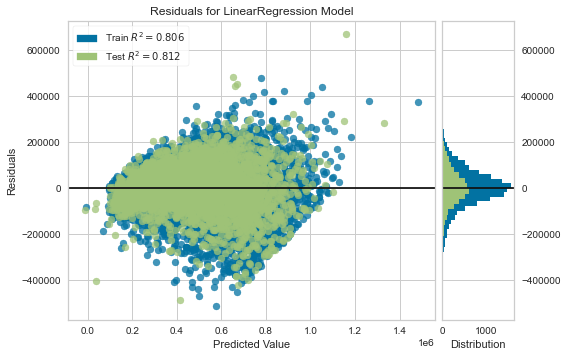

In [36]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

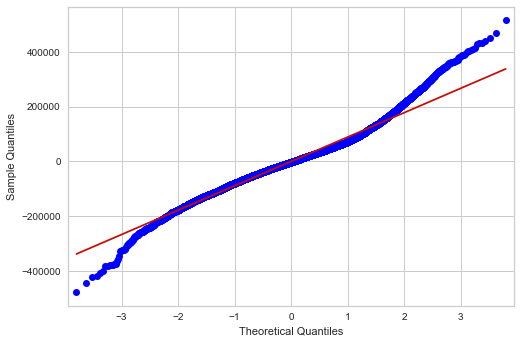

In [37]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

##### Model 6b

In [38]:
cols = ['sqft_living', 'bathrooms', 'yr_built'] + encoded_bedroom_bin + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [39]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8078044199599432
Test Score: 0.8143669163699321


In [40]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.808
Mean Absolute Error: 65731.199
Mean Squared Error: 8034363359.516
Root Mean Squared Error: 89634.610

Testing Metrics:
R2: 0.814
Mean Absolute Error: 63962.932
Mean Squared Error: 7652726437.574
Root Mean Squared Error: 87479.863


#### Model 7

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'condition', 'view', and 'zipcode'. 

In [41]:
cols = ['sqft_living', 'sqft_living15', 'bedrooms', 'bathrooms', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [42]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8162984121309026
Test Score: 0.8209083160697839


In [43]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.816
Mean Absolute Error: 64187.454
Mean Squared Error: 7679288495.359
Root Mean Squared Error: 87631.550

Testing Metrics:
R2: 0.821
Mean Absolute Error: 63030.485
Mean Squared Error: 7383057144.564
Root Mean Squared Error: 85924.718


I want to take a look at the interaction between sqft_living and sqft_living15.

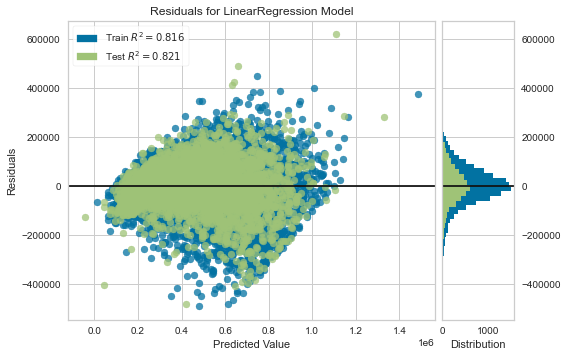

In [44]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

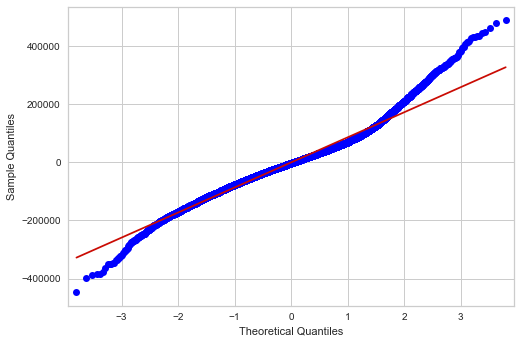

In [45]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

##### Model 7b

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'bedroom_bin', 'condition', 'view', and 'zipcode'.

In [46]:
cols = ['sqft_living', 'sqft_living15', 'bathrooms', 'yr_built'] + encoded_bedroom_bin + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [47]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8177610258953996
Test Score: 0.822780574427596


In [48]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.818
Mean Absolute Error: 63854.277
Mean Squared Error: 7618146764.440
Root Mean Squared Error: 87281.996

Testing Metrics:
R2: 0.823
Mean Absolute Error: 62643.044
Mean Squared Error: 7305873267.894
Root Mean Squared Error: 85474.401


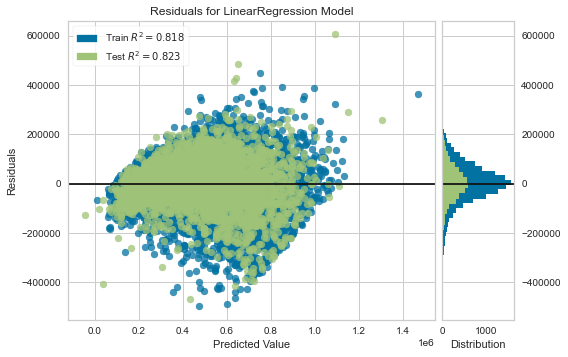

In [49]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

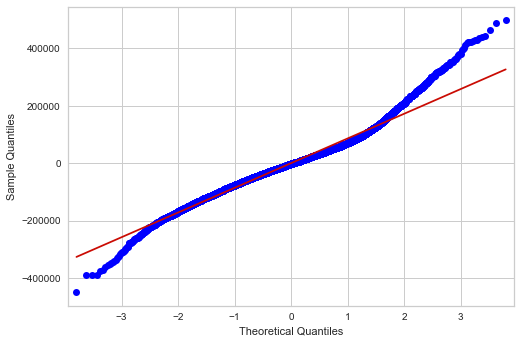

In [50]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

#### Model 8

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built', 'waterfront' and the columns created from encoding 'bedroom_bin', 'condition', 'view', and 'zipcode'.

In [51]:
cols = ['sqft_living', 'sqft_living15', 'bathrooms', 'yr_built', 'waterfront'] + encoded_bedroom_bin + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [52]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_n_score(x,y,x2,y2)

Training Score: 0.8189366394823843
Test Score: 0.8231272326919331


In [53]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.819
Mean Absolute Error: 63760.370
Mean Squared Error: 7569002519.155
Root Mean Squared Error: 87000.014

Testing Metrics:
R2: 0.823
Mean Absolute Error: 62626.476
Mean Squared Error: 7291582276.157
Root Mean Squared Error: 85390.762


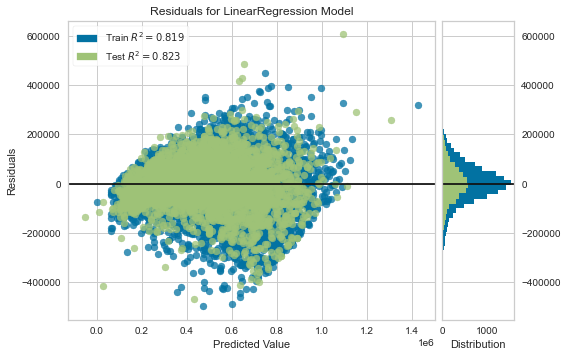

In [54]:
lr = LinearRegression()
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

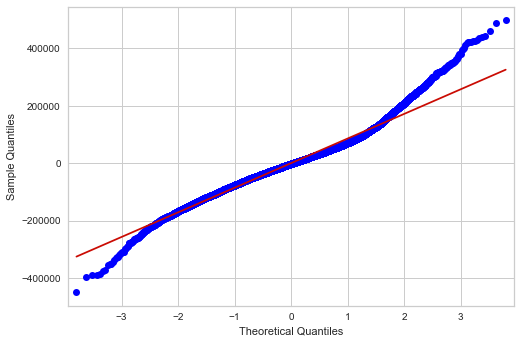

In [55]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

In [56]:
y = y_train
x = X_train.filter(cols, axis=1)
x = sm.add_constant(x)
model = sm.OLS(y, x.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     697.5
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:56:22   Log-Likelihood:            -1.7473e+05
No. Observations:               13659   AIC:                         3.496e+05
Df Residuals:                   13570   BIC:                         3.503e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.643e+05   7.53e+04      6.164      0.000    3.17e+05    6.12e+05
sqft_living              123.7037      2.081     59.434      0.000     119.624     127.783
sqft_living15             59.4251      2.161     27.493      0.000      55.188      63.662
bathrooms               1.369e+04   1811.666      7.554      0.000    1.01e+04    1.72e+04
yr_built                -263.1905     38.495     -6.837      0.000    -338.647    -187.734
waterfront              1.974e+05    2.1e+04      9.387      0.000    1.56e+05    2.39e+05
bedrooms_bin_x0_2BR      1.36e+04   8494.478      1.601      0.109   -3052.134    3.02e+04
bedrooms_bin_x0_3BR     1.675e+04   8443.051      1.984      0.047     203.311    3.33e+04
bedrooms_bin_x0_4BR      1.06e+04   8648.116      1.226      0.220   -6350.503    2.76e+04
bedrooms_bin_x0_5BR    -1.697e+04   9184.030     -1.847      0.065    -3.5e+04    1035.542
bedrooms_bin_x0_6BR    -3.753e+04   1.15e+04     -3.252      0.001   -6.02e+04   -1.49e+04
bedrooms_bin_x0_7+BR   -1.256e+05   2.05e+04     -6.118      0.000   -1.66e+05   -8.54e+04
condition_x0_Fair      -3.411e+04   8760.459     -3.893      0.000   -5.13e+04   -1.69e+04
condition_x0_Good       1.176e+04   1935.611      6.076      0.000    7966.531    1.56e+04
condition_x0_Poor      -1.659e+05   2.35e+04     -7.046      0.000   -2.12e+05    -1.2e+05
condition_x0_Very Good  4.152e+04   3041.192     13.654      0.000    3.56e+04    4.75e+04
view_x0_EXCELLENT       1.132e+05   1.12e+04     10.083      0.000    9.12e+04    1.35e+05
view_x0_FAIR           -1.542e+04   7544.037     -2.044      0.041   -3.02e+04    -635.707
view_x0_GOOD             3.03e+04   7382.761      4.104      0.000    1.58e+04    4.48e+04
view_x0_NONE           -6.074e+04   4137.217    -14.681      0.000   -6.88e+04   -5.26e+04
zipcode_x0_98002         1.34e+04   9505.219      1.410      0.159   -5230.928     3.2e+04
zipcode_x0_98003        7782.9612   8557.901      0.909      0.363   -8991.713    2.46e+04
zipcode_x0_98004        5.282e+05   1.05e+04     50.420      0.000    5.08e+05    5.49e+05
zipcode_x0_98005        3.609e+05   1.16e+04     31.178      0.000    3.38e+05    3.84e+05
zipcode_x0_98006        2.927e+05   8011.694     36.540      0.000    2.77e+05    3.08e+05
zipcode_x0_98007        2.683e+05   1.09e+04     24.700      0.000    2.47e+05     2.9e+05
zipcode_x0_98008        2.515e+05   8719.170     28.846      0.000    2.34e+05    2.69e+05
zipcode_x0_98010        9.421e+04   1.52e+04      6.199      0.000    6.44e+04    1.24e+05
zipcode_x0_98011        1.509e+05   9743.894     15.491      0.000    1.32e+05     1.7e+05
zipcode_x0_98014        1.144e+05   1.54e+04      7.445      0.000    8.43e+04    1.45e+05
zipcode_x0_98019        9.239e+04   1.01e+04      9.168      0.000    7.26e+04  

In [57]:
sum(model.pvalues > .05)

13

In [58]:
sum(model.pvalues > .05) / len(model.pvalues)

0.14606741573033707

In [59]:
y = y_test
x = X_test.filter(cols, axis=1)
x = sm.add_constant(x)
model = sm.OLS(y, x.astype(float)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     246.6
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:56:23   Log-Likelihood:                -58078.
No. Observations:                4553   AIC:                         1.163e+05
Df Residuals:                    4464   BIC:                         1.169e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.182e+05   1.27e+05      0.932      0.352   -1.31e+05    3.67e+05
sqft_living              126.6618      3.533     35.849      0.000     119.735     133.589
sqft_living15             53.5592      3.693     14.504      0.000      46.320      60.799
bathrooms               1.079e+04   3008.849      3.585      0.000    4888.491    1.67e+04
yr_built                 -86.3830     64.760     -1.334      0.182    -213.344      40.578
waterfront              1.894e+05   5.63e+04      3.363      0.001     7.9e+04       3e+05
bedrooms_bin_x0_2BR     1.118e+04   1.19e+04      0.939      0.348   -1.21e+04    3.45e+04
bedrooms_bin_x0_3BR     1.561e+04   1.18e+04      1.329      0.184   -7425.299    3.86e+04
bedrooms_bin_x0_4BR     1.142e+04   1.22e+04      0.937      0.349   -1.25e+04    3.53e+04
bedrooms_bin_x0_5BR    -1.276e+04   1.33e+04     -0.962      0.336   -3.88e+04    1.33e+04
bedrooms_bin_x0_6BR     -5.56e+04   1.69e+04     -3.285      0.001   -8.88e+04   -2.24e+04
bedrooms_bin_x0_7+BR   -9.707e+04   2.45e+04     -3.957      0.000   -1.45e+05    -4.9e+04
condition_x0_Fair      -3.194e+04   1.61e+04     -1.986      0.047   -6.35e+04    -405.968
condition_x0_Good       1.136e+04   3282.756      3.460      0.001    4922.461    1.78e+04
condition_x0_Poor      -7.795e+04   3.28e+04     -2.379      0.017   -1.42e+05   -1.37e+04
condition_x0_Very Good  4.116e+04   5184.667      7.938      0.000     3.1e+04    5.13e+04
view_x0_EXCELLENT       1.062e+05   2.54e+04      4.176      0.000    5.63e+04    1.56e+05
view_x0_FAIR            4700.7322   1.28e+04      0.366      0.714   -2.05e+04    2.99e+04
view_x0_GOOD            4.587e+04   1.28e+04      3.592      0.000    2.08e+04    7.09e+04
view_x0_NONE            -4.82e+04   6749.635     -7.141      0.000   -6.14e+04    -3.5e+04
zipcode_x0_98002        5335.6234   1.48e+04      0.359      0.719   -2.38e+04    3.44e+04
zipcode_x0_98003        8162.2022   1.42e+04      0.576      0.564   -1.96e+04    3.59e+04
zipcode_x0_98004        5.078e+05   1.72e+04     29.550      0.000    4.74e+05    5.41e+05
zipcode_x0_98005         3.19e+05   1.79e+04     17.824      0.000    2.84e+05    3.54e+05
zipcode_x0_98006        2.922e+05   1.32e+04     22.140      0.000    2.66e+05    3.18e+05
zipcode_x0_98007        2.933e+05   1.66e+04     17.628      0.000    2.61e+05    3.26e+05
zipcode_x0_98008        2.519e+05   1.42e+04     17.781      0.000    2.24e+05     2.8e+05
zipcode_x0_98010        7.125e+04   3.34e+04      2.132      0.033    5735.486    1.37e+05
zipcode_x0_98011        1.405e+05    1.5e+04      9.378      0.000    1.11e+05     1.7e+05
zipcode_x0_98014        1.145e+05   2.99e+04      3.834      0.000     5.6e+04    1.73e+05
zipcode_x0_98019        8.243e+04   1.87e+04      4.406      0.000    4.58e+04  

In [60]:
sum(model.pvalues > .05)

17

In [61]:
sum(model.pvalues > .05) / len(model.pvalues)

0.19101123595505617